In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Add parent directory (data/) to path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from database.connection import get_db_manager
from sqlalchemy import text

In [2]:
# Metrics that should NOT be divided by 90 (already normalized or %)
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Challenges_Tkl%', 'CS%', 'Poss',
    'Aerial Duels_Won%', 'Take-Ons_Succ%', 'Save%', 'Launched_Cmp%', 'Goal Kicks_Launch%',
    'SCA_SCA90', 'GCA_GCA90', 'GA90', 'SoT/90', 'shots_per_90', 'Team Success_+/-90',
    'Team Success (xG)_xG+/-90', 'Sweeper_#OPA/90', '/90',
    'understat_ppda_avg', 'understat_ppda_std', 'understat_deep_completions_avg',
    'understat_np_xg_avg', 'understat_expected_points_avg', 'understat_points_efficiency',
    'matches_played', 'minutes_played', 'full_matches_equivalent', 'minutes_per_match',
    'wins', 'draws', 'losses', 'points', 'players_used',
    'goals_per_shot', 'goals_per_shot_on_target', 'npxG/Sh', 'xG+xAG',
    'avg_shot_distance', 'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Sweeper_AvgDist',
    'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%', 'Team Success_PPM',
    'data_quality_score', 'url', 'official_team_name', 'processing_warnings'
}

# Radar profiles for teams (10 metrics each)
attack_metrics = [
    'goals_per90', 'non_penalty_goals_per90', 'expected_goals_per90', 'shots_per_90',
    'shots_on_target_pct', 'goals_per_shot', 'goals_per_shot_on_target', 'npxG/Sh',
    'understat_np_xg_avg', 'SCA_SCA90'
]
attack_titles = [
    'Goals', 'Non-Penalty Goals', 'xG', 'Shots',
    'Shot Accuracy %', 'Goals/Shot', 'Conversion Rate', 'npxG/Shot',
    'npxG Avg', 'Shot Creating Actions'
]

defense_metrics = [
    'goals_against_per90', 'CS%', 'Tackles_Tkl_per90', 'tackles_won_per90',
    'Challenges_Tkl%', 'interceptions_per90', 'Tkl+Int_per90', 'clearances_per90',
    'Blocks_Blocks_per90', 'understat_ppda_avg'
]
defense_titles = [
    'Goals Against', 'Clean Sheet %', 'Tackles', 'Tackles Won',
    'Tackle Success %', 'Interceptions', 'Tkl + Int', 'Clearances',
    'Blocks', 'PPDA (Pressing)'
]

creation_metrics = [
    'Poss', 'pass_completion_pct', 'progressive_passes_per90', 'key_passes_per90',
    'passes_penalty_area_per90', 'expected_assists_per90', 'GCA_GCA90',
    'Progression_PrgC_per90', 'Take-Ons_Succ_per90', 'understat_deep_completions_avg'
]
creation_titles = [
    'Possession %', 'Pass Accuracy %', 'Progressive Passes', 'Key Passes',
    'Box Passes', 'xA', 'Goal Creating Actions',
    'Progressive Carries', 'Successful Dribbles', 'Deep Completions'
]

SAVE_PATH_BASE = '../images/arsenal_comparison/'
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Helper functions
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 3:  # Lower threshold for teams (fewer rows)
            result[key] = values
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None:
        return np.nan
    if isinstance(value, (list, np.ndarray)):
        return np.nan
    try:
        if pd.isna(value):
            return np.nan
    except (ValueError, TypeError):
        pass
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x)
    return df

In [4]:
# STEP 1: Query Big5 TEAMS season 24/25
print("="*60)
print("STEP 1: BIG5 TEAMS SEASON 24/25")
print("="*60)

db = get_db_manager()

LEAGUES_BIG5 = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON_2425 = '2425'

league_list_str = "', '".join(LEAGUES_BIG5)
query_2425 = f"""
SELECT 
    unique_team_id,
    team_name,
    league,
    season,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.teams_domestic
WHERE league IN ('{league_list_str}')
AND season = '{SEASON_2425}'
ORDER BY league, team_name
"""

df_2425_raw = pd.read_sql(query_2425, db.engine)
print(f"Extracted Big5 24/25: {df_2425_raw.shape[0]} teams")

# Extract metrics
fbref_2425 = extract_metrics(df_2425_raw, 'fbref_metrics')
understat_2425 = extract_metrics(df_2425_raw, 'understat_metrics')

# Calculate per90 for metrics that need it
matches_col = fbref_2425['matches_played'] if 'matches_played' in fbref_2425.columns else 38

fbref_2425_per90 = fbref_2425.loc[:, ~fbref_2425.columns.isin(exclude_per90)]
fbref_2425_per90 = (fbref_2425_per90.div(matches_col, axis=0)).round(3)
fbref_2425_per90.columns = [f'{col}_per90' for col in fbref_2425_per90.columns]

# Combine all metrics
all_metrics_2425 = pd.concat([fbref_2425, understat_2425, fbref_2425_per90], axis=1).copy()
all_metrics_2425 = all_metrics_2425.loc[:, ~all_metrics_2425.columns.duplicated()]

# Metrics where LESS is BETTER (need inverted percentiles)
inverted_metrics = {'goals_against', 'goals_against_per90', 'understat_ppda_avg', 'errors', 'errors_per90'}

# Calculate percentiles within cohort
numeric_cols = all_metrics_2425.select_dtypes(include=[np.number]).columns
all_percentiles_2425 = pd.DataFrame(index=all_metrics_2425.index)

for col in numeric_cols:
    if col in inverted_metrics:
        # Less is better: ascending=False means lowest value gets highest percentile
        all_percentiles_2425[f'{col}_pct'] = (all_metrics_2425[col].rank(pct=True, ascending=False) * 98 + 1).round(0).astype('Int64')
    else:
        # More is better: normal ranking
        all_percentiles_2425[f'{col}_pct'] = (all_metrics_2425[col].rank(pct=True) * 98 + 1).round(0).astype('Int64')

# Create final DataFrame
base_cols = ['unique_team_id', 'team_name', 'league', 'season']
df_2425 = pd.concat([
    df_2425_raw[base_cols].reset_index(drop=True),
    all_metrics_2425.reset_index(drop=True),
    all_percentiles_2425.reset_index(drop=True)
], axis=1).copy()

df_2425 = df_2425.loc[:, ~df_2425.columns.duplicated()]
df_2425 = clean_series_values(df_2425)
df_2425['cohort'] = 'Big5_2425'

print(f"DataFrame 24/25: {df_2425.shape[0]} rows, {df_2425.shape[1]} columns")
print(f"Percentiles calculated within Big5 24/25 cohort")
print(f"Inverted metrics (less is better): {inverted_metrics}")

# Verify Arsenal
arsenal = df_2425[df_2425['team_name'] == 'Arsenal']
print(f"\nArsenal 24/25 check:")
print(f"  goals_against: {arsenal['goals_against'].values[0]} -> pct: {arsenal['goals_against_pct'].values[0]}")
print(f"  goals: {arsenal['goals'].values[0]} -> pct: {arsenal['goals_pct'].values[0]}")

2025-11-21 09:01:06,505 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-11-21 09:01:06,667 - database.connection - INFO - Database connection successful


STEP 1: BIG5 TEAMS SEASON 24/25
Extracted Big5 24/25: 96 teams
DataFrame 24/25: 96 rows, 680 columns
Percentiles calculated within Big5 24/25 cohort
Inverted metrics (less is better): {'goals_against', 'understat_ppda_avg', 'errors_per90', 'goals_against_per90', 'errors'}

Arsenal 24/25 check:
  goals_against: 34.0 -> pct: 95
  goals: 67.0 -> pct: 85


In [5]:
# STEP 2: Query Big5 TEAMS season 25/26
print("\n" + "="*60)
print("STEP 2: BIG5 TEAMS SEASON 25/26")
print("="*60)

SEASON_2526 = '2526'

query_2526 = f"""
SELECT 
    unique_team_id,
    team_name,
    league,
    season,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.teams_domestic
WHERE league IN ('{league_list_str}')
AND season = '{SEASON_2526}'
ORDER BY league, team_name
"""

df_2526_raw = pd.read_sql(query_2526, db.engine)
print(f"Extracted Big5 25/26: {df_2526_raw.shape[0]} teams")

# Extract metrics
fbref_2526 = extract_metrics(df_2526_raw, 'fbref_metrics')
understat_2526 = extract_metrics(df_2526_raw, 'understat_metrics')

# Calculate per90
matches_col_2526 = fbref_2526['matches_played'] if 'matches_played' in fbref_2526.columns else 38

fbref_2526_per90 = fbref_2526.loc[:, ~fbref_2526.columns.isin(exclude_per90)]
fbref_2526_per90 = (fbref_2526_per90.div(matches_col_2526, axis=0)).round(3)
fbref_2526_per90.columns = [f'{col}_per90' for col in fbref_2526_per90.columns]

# Combine all metrics
all_metrics_2526 = pd.concat([fbref_2526, understat_2526, fbref_2526_per90], axis=1).copy()
all_metrics_2526 = all_metrics_2526.loc[:, ~all_metrics_2526.columns.duplicated()]

# Calculate percentiles within cohort (same inverted metrics)
numeric_cols_2526 = all_metrics_2526.select_dtypes(include=[np.number]).columns
all_percentiles_2526 = pd.DataFrame(index=all_metrics_2526.index)

for col in numeric_cols_2526:
    if col in inverted_metrics:
        # Less is better: ascending=False means lowest value gets highest percentile
        all_percentiles_2526[f'{col}_pct'] = (all_metrics_2526[col].rank(pct=True, ascending=False) * 98 + 1).round(0).astype('Int64')
    else:
        # More is better: normal ranking
        all_percentiles_2526[f'{col}_pct'] = (all_metrics_2526[col].rank(pct=True) * 98 + 1).round(0).astype('Int64')

# Create final DataFrame
df_2526 = pd.concat([
    df_2526_raw[base_cols].reset_index(drop=True),
    all_metrics_2526.reset_index(drop=True),
    all_percentiles_2526.reset_index(drop=True)
], axis=1).copy()

df_2526 = df_2526.loc[:, ~df_2526.columns.duplicated()]
df_2526 = clean_series_values(df_2526)
df_2526['cohort'] = 'Big5_2526'

print(f"DataFrame 25/26: {df_2526.shape[0]} rows, {df_2526.shape[1]} columns")
print(f"Percentiles calculated within Big5 25/26 cohort")

# Verify Arsenal
arsenal = df_2526[df_2526['team_name'] == 'Arsenal']
print(f"\nArsenal 25/26 check:")
print(f"  goals_against: {arsenal['goals_against'].values[0]} -> pct: {arsenal['goals_against_pct'].values[0]}")
print(f"  goals: {arsenal['goals'].values[0]} -> pct: {arsenal['goals_pct'].values[0]}")


STEP 2: BIG5 TEAMS SEASON 25/26
Extracted Big5 25/26: 96 teams
DataFrame 25/26: 96 rows, 688 columns
Percentiles calculated within Big5 25/26 cohort

Arsenal 25/26 check:
  goals_against: 5.0 -> pct: 98
  goals: 20.0 -> pct: 82


In [6]:
# STEP 3: Union both DataFrames
print("\n" + "="*60)
print("STEP 3: UNION DATAFRAMES")
print("="*60)

# Get common columns between both DataFrames
common_cols = list(set(df_2425.columns) & set(df_2526.columns))
print(f"Common columns: {len(common_cols)}")

# Use only common columns for concat
df_final = pd.concat([df_2425[common_cols], df_2526[common_cols]], ignore_index=True).copy()

# Remove any remaining duplicate columns
df_final = df_final.loc[:, ~df_final.columns.duplicated()]

# Create unique ID combining team_id + season for comparison
df_final['comparison_id'] = df_final['unique_team_id'] + '_' + df_final['season']

print(f"DataFrame final: {df_final.shape[0]} rows, {df_final.shape[1]} columns")
print(f"\nCohorts:")
print(df_final['cohort'].value_counts())
print(f"\nSeasons:")
print(df_final['season'].value_counts())

# Find Arsenal IDs - now using comparison_id
arsenal_2425 = df_final[(df_final['team_name'] == 'Arsenal') & (df_final['season'] == '2425')]
arsenal_2526 = df_final[(df_final['team_name'] == 'Arsenal') & (df_final['season'] == '2526')]

print(f"\nArsenal 24/25 comparison_id: {arsenal_2425['comparison_id'].values[0] if len(arsenal_2425) > 0 else 'NOT FOUND'}")
print(f"Arsenal 25/26 comparison_id: {arsenal_2526['comparison_id'].values[0] if len(arsenal_2526) > 0 else 'NOT FOUND'}")

arsenal_id_2425 = arsenal_2425['comparison_id'].values[0] if len(arsenal_2425) > 0 else None
arsenal_id_2526 = arsenal_2526['comparison_id'].values[0] if len(arsenal_2526) > 0 else None

db.close()


STEP 3: UNION DATAFRAMES
Common columns: 680
DataFrame final: 192 rows, 681 columns

Cohorts:
cohort
Big5_2425    96
Big5_2526    96
Name: count, dtype: int64

Seasons:
season
2425    96
2526    96
Name: count, dtype: int64

Arsenal 24/25 comparison_id: b98cc2f578c02641_2425
Arsenal 25/26 comparison_id: b98cc2f578c02641_2526


In [7]:
# STEP 5: Verify all metrics are available
print("\n" + "="*60)
print("STEP 5: VERIFY METRICS")
print("="*60)

# Check all metrics
all_metrics_lists = [
    ('Attack', attack_metrics, attack_titles),
    ('Defense', defense_metrics, defense_titles),
    ('Creation', creation_metrics, creation_titles)
]

for name, metrics, titles in all_metrics_lists:
    print(f"\n{name} metrics:")
    missing = []
    for m in metrics:
        if m not in df_final.columns:
            missing.append(m)
            print(f"  {m}: MISSING")
        else:
            print(f"  {m}: OK")
    if missing:
        print(f"  WARNING: {len(missing)} metrics missing!")
    else:
        print(f"  All 10 metrics available")


STEP 5: VERIFY METRICS

Attack metrics:
  goals_per90: OK
  non_penalty_goals_per90: OK
  expected_goals_per90: OK
  shots_per_90: OK
  shots_on_target_pct: OK
  goals_per_shot: OK
  goals_per_shot_on_target: OK
  npxG/Sh: OK
  understat_np_xg_avg: OK
  SCA_SCA90: OK
  All 10 metrics available

Defense metrics:
  goals_against_per90: OK
  CS%: OK
  Tackles_Tkl_per90: OK
  tackles_won_per90: OK
  Challenges_Tkl%: OK
  interceptions_per90: OK
  Tkl+Int_per90: OK
  clearances_per90: OK
  Blocks_Blocks_per90: OK
  understat_ppda_avg: OK
  All 10 metrics available

Creation metrics:
  Poss: OK
  pass_completion_pct: OK
  progressive_passes_per90: OK
  key_passes_per90: OK
  passes_penalty_area_per90: OK
  expected_assists_per90: OK
  GCA_GCA90: OK
  Progression_PrgC_per90: OK
  Take-Ons_Succ_per90: OK
  understat_deep_completions_avg: OK
  All 10 metrics available


In [8]:
# STEP 6: Create radars
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("\n" + "="*60)
print("STEP 6: CREATE RADARS")
print("="*60)

# Arsenal colors from template
arsenal_red = '#FF6B6B'  # Coral Red
arsenal_white = '#FFFFFF'
team_colors = [arsenal_red, arsenal_white]

# Team logos
team_logos = {
    'Arsenal': '../logos/PL/Arsenal FC.png'
}

# Use comparison_id as unique_team_id for radar functions
df_final['unique_team_id'] = df_final['comparison_id']

if arsenal_id_2425 and arsenal_id_2526:
    print(f"Arsenal 24/25 ID: {arsenal_id_2425}")
    print(f"Arsenal 25/26 ID: {arsenal_id_2526}")
    
    # Verify inverted metrics
    a24 = df_final[df_final['comparison_id'] == arsenal_id_2425].iloc[0]
    a25 = df_final[df_final['comparison_id'] == arsenal_id_2526].iloc[0]
    print(f"\nVerification (inverted metrics - less is better = higher pct):")
    print(f"  24/25: goals_against={a24['goals_against']}, pct={a24['goals_against_pct']}")
    print(f"  25/26: goals_against={a25['goals_against']}, pct={a25['goals_against_pct']}")
else:
    print("ERROR: Arsenal IDs not found")


STEP 6: CREATE RADARS
Arsenal 24/25 ID: b98cc2f578c02641_2425
Arsenal 25/26 ID: b98cc2f578c02641_2526

Verification (inverted metrics - less is better = higher pct):
  24/25: goals_against=34.0, pct=95
  25/26: goals_against=5.0, pct=98



RADAR 1: ATTACK
OK: arsenal_attack_combined.png


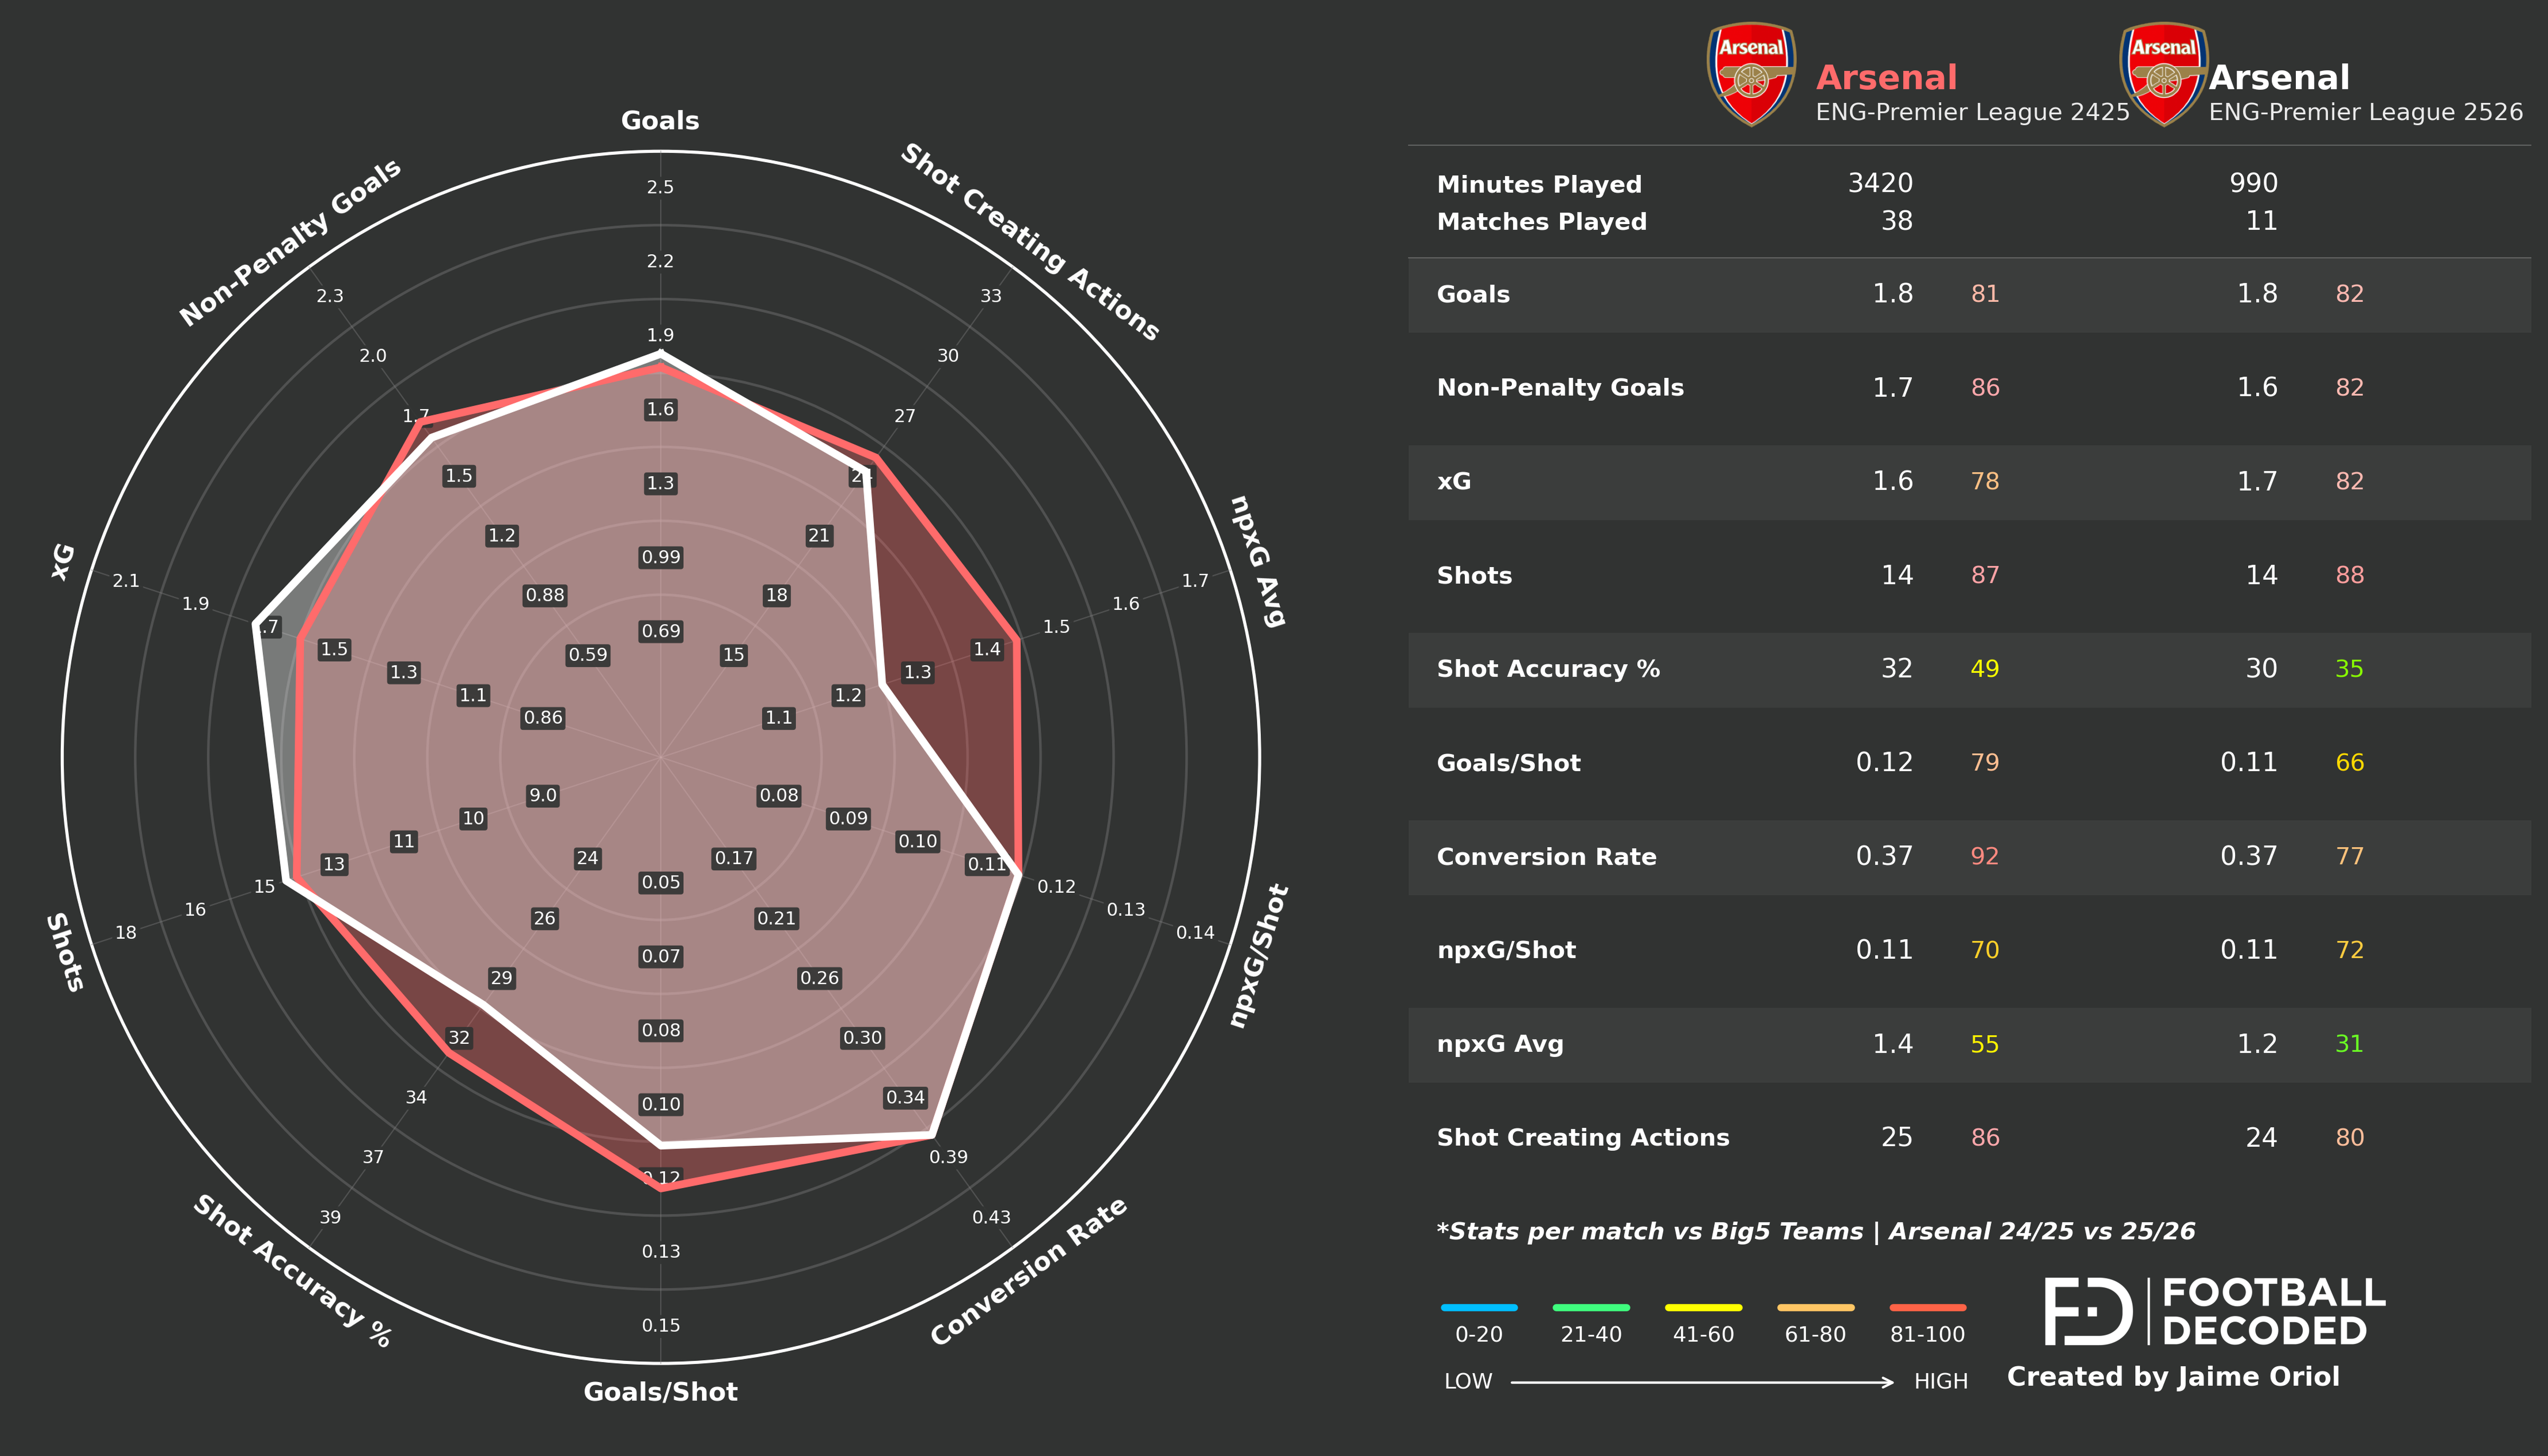

In [9]:
# RADAR 1: ATTACK
print("\n" + "="*60)
print("RADAR 1: ATTACK")
print("="*60)

if arsenal_id_2425 and arsenal_id_2526:
    try:
        # Create radar
        create_player_radar(
            df_data=df_final,
            player_1_id=arsenal_id_2425,
            player_2_id=arsenal_id_2526,
            metrics=attack_metrics,
            metric_titles=attack_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}arsenal_attack_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Create table
        create_stats_table(
            df_data=df_final,
            player_1_id=arsenal_id_2425,
            player_2_id=arsenal_id_2526,
            metrics=attack_metrics,
            metric_titles=attack_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}arsenal_attack_table.png",
            footer_text="Stats per match vs Big5 Teams | Arsenal 24/25 vs 25/26",
            show_plot=False
        )
        
        # Combine
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}arsenal_attack_radar.png",
            table_path=f"{SAVE_PATH_BASE}arsenal_attack_table.png",
            output_path=f"{SAVE_PATH_BASE}arsenal_attack_combined.png"
        )
        
        print(f"OK: arsenal_attack_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}arsenal_attack_combined.png"))
    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()


RADAR 2: DEFENSE
OK: arsenal_defense_combined.png


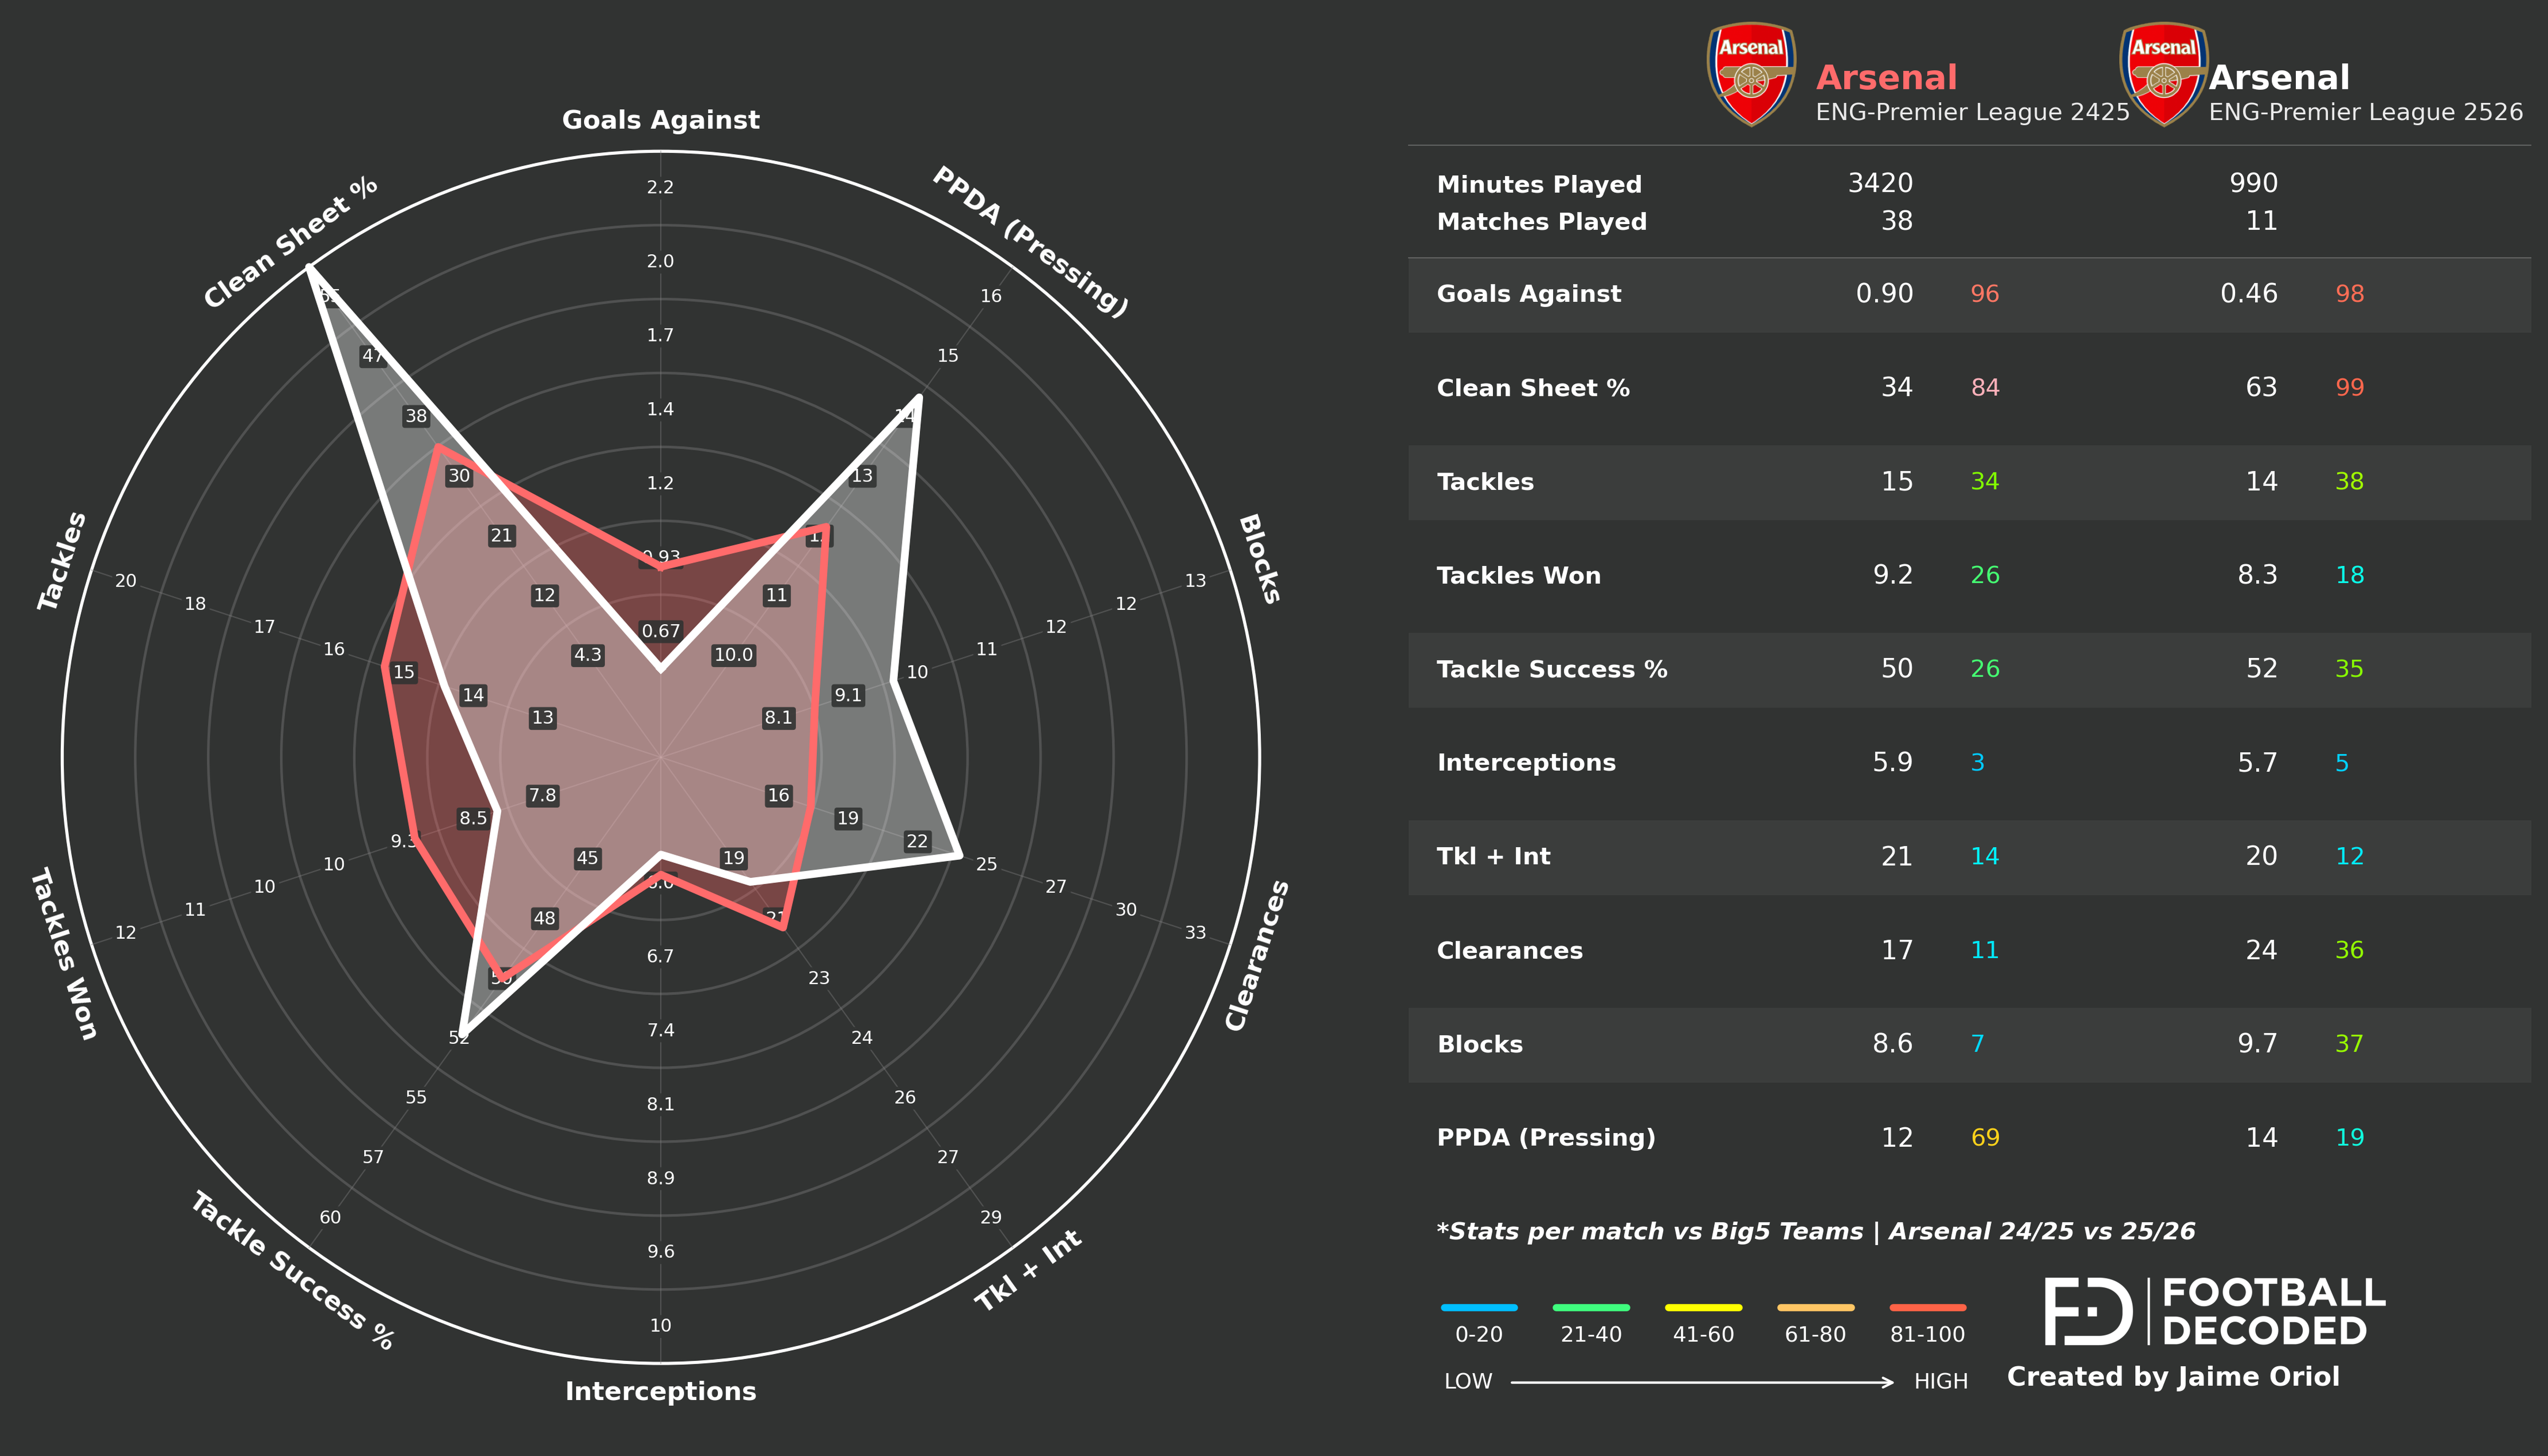

In [10]:
# RADAR 2: DEFENSE
print("\n" + "="*60)
print("RADAR 2: DEFENSE")
print("="*60)

if arsenal_id_2425 and arsenal_id_2526:
    try:
        # Create radar
        create_player_radar(
            df_data=df_final,
            player_1_id=arsenal_id_2425,
            player_2_id=arsenal_id_2526,
            metrics=defense_metrics,
            metric_titles=defense_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}arsenal_defense_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Create table
        create_stats_table(
            df_data=df_final,
            player_1_id=arsenal_id_2425,
            player_2_id=arsenal_id_2526,
            metrics=defense_metrics,
            metric_titles=defense_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}arsenal_defense_table.png",
            footer_text="Stats per match vs Big5 Teams | Arsenal 24/25 vs 25/26",
            show_plot=False
        )
        
        # Combine
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}arsenal_defense_radar.png",
            table_path=f"{SAVE_PATH_BASE}arsenal_defense_table.png",
            output_path=f"{SAVE_PATH_BASE}arsenal_defense_combined.png"
        )
        
        print(f"OK: arsenal_defense_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}arsenal_defense_combined.png"))
    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()


RADAR 3: CREATION
OK: arsenal_creation_combined.png


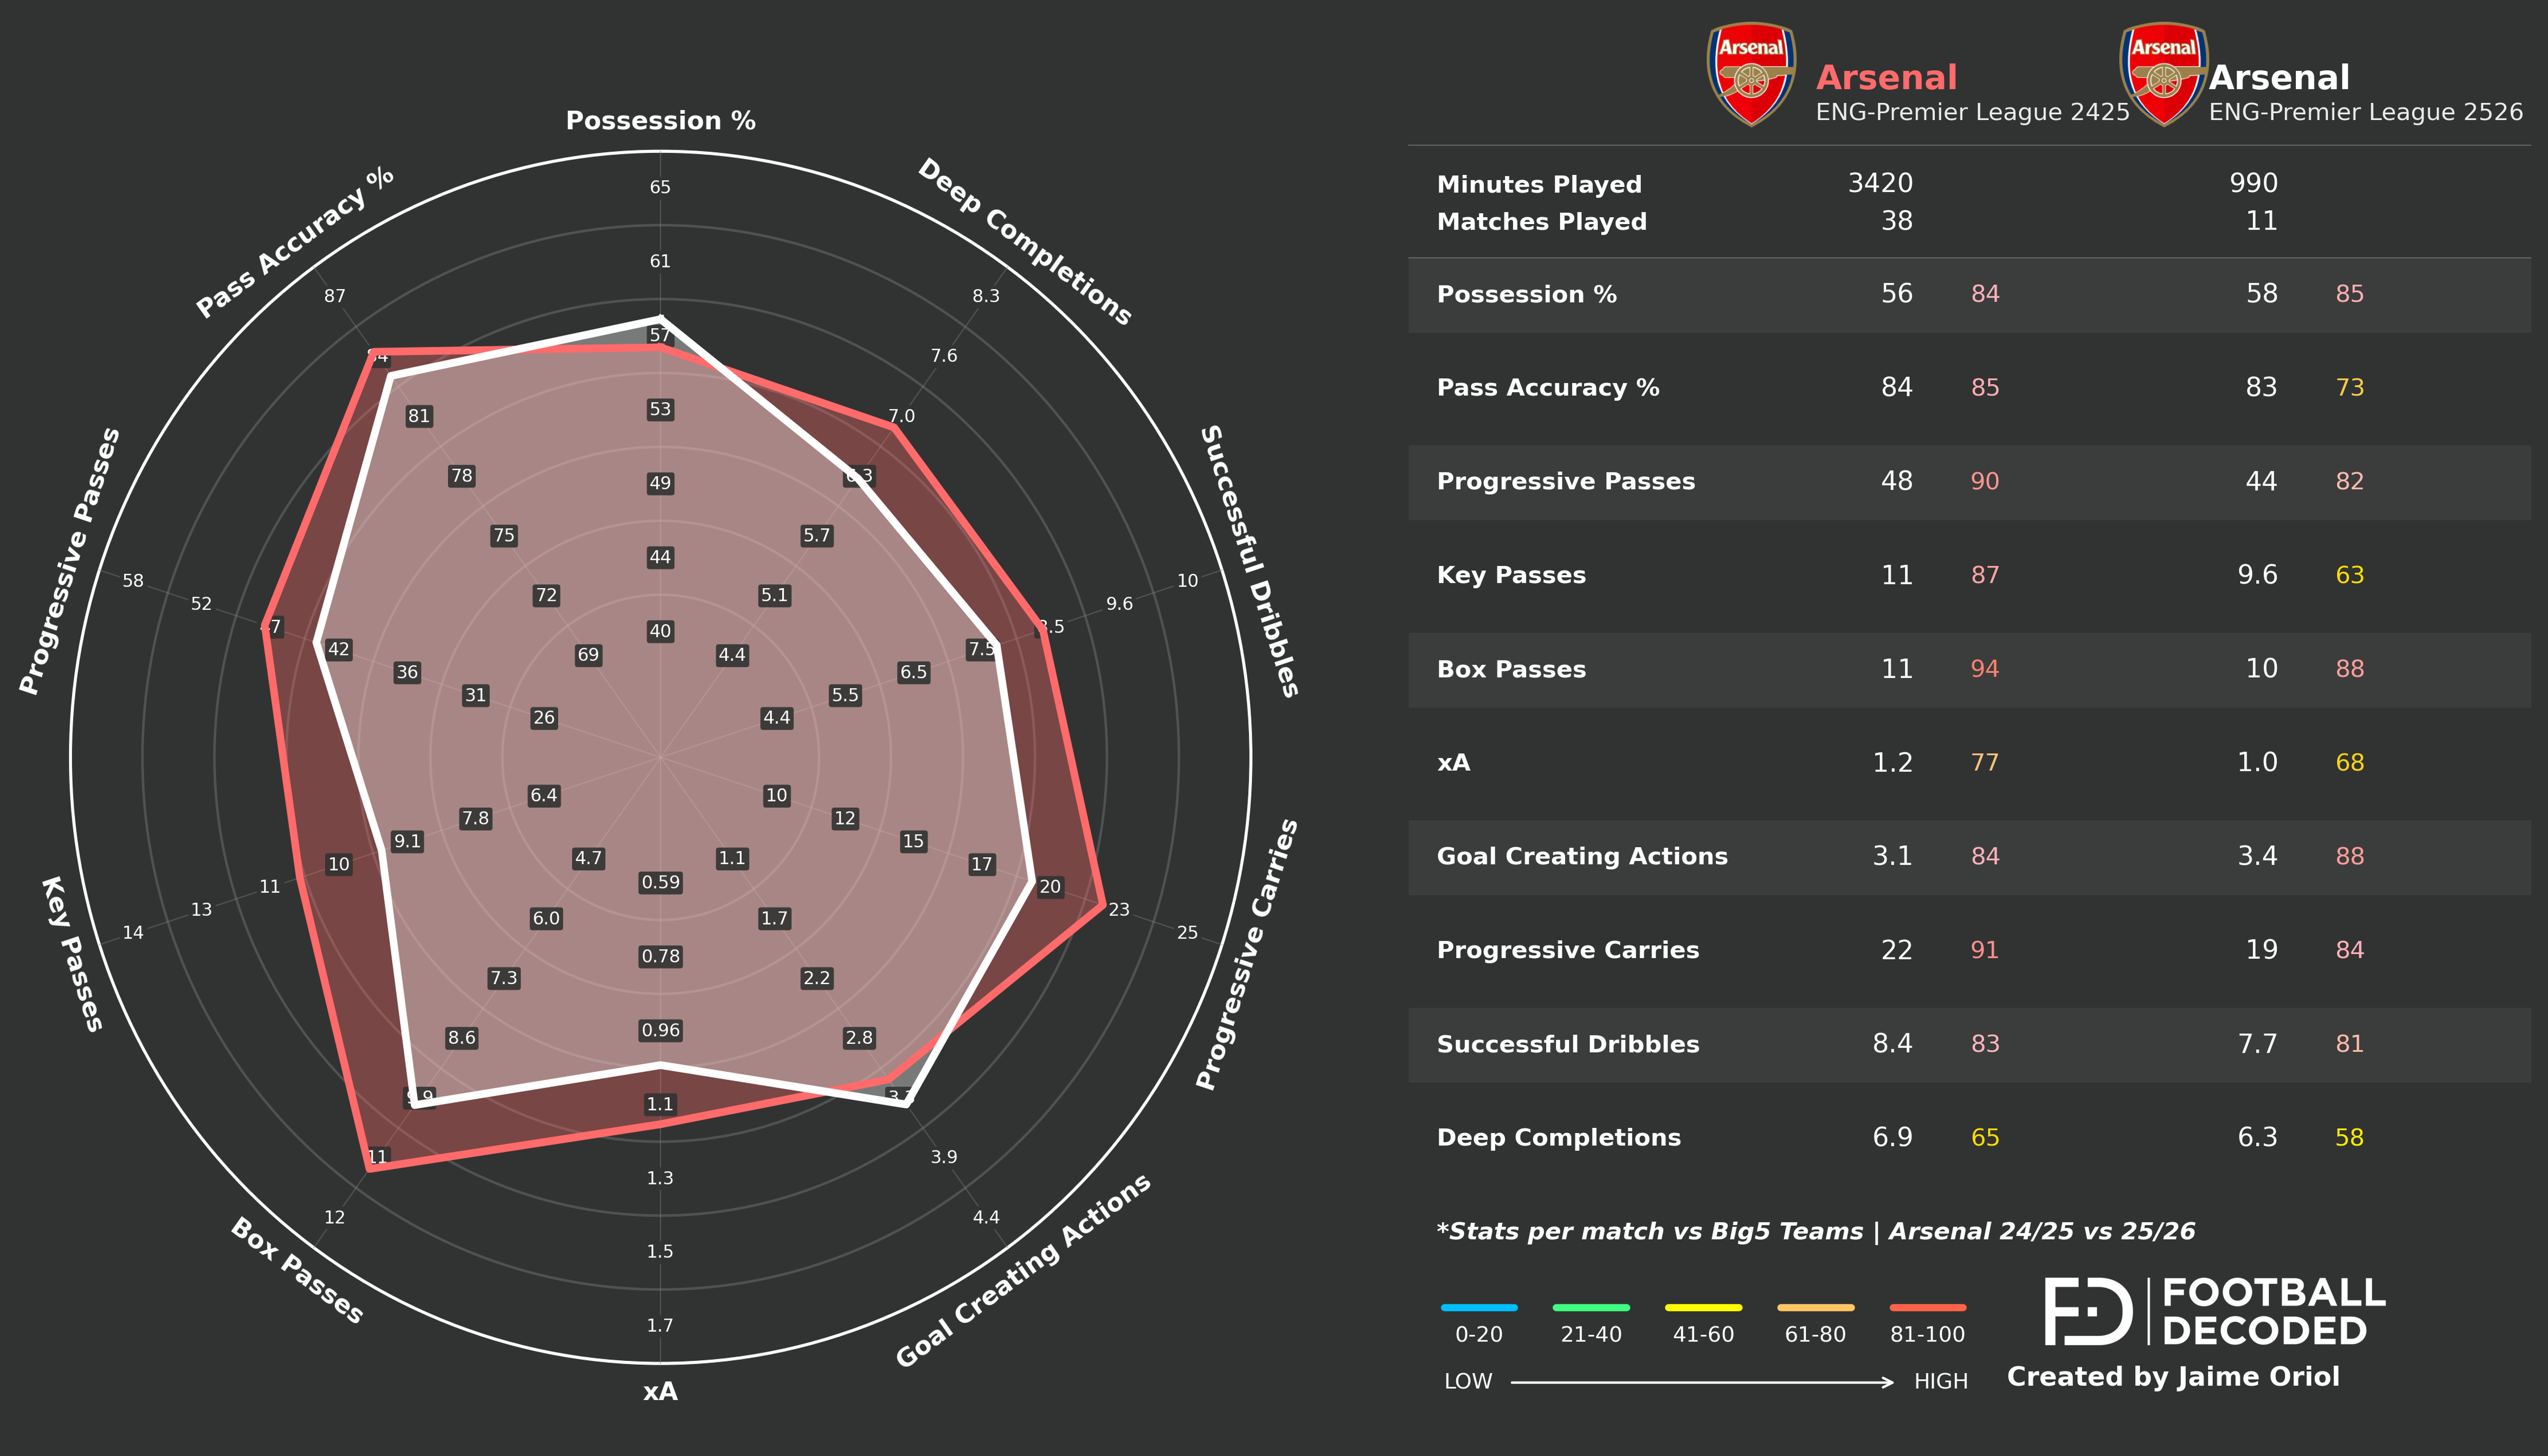


ALL RADARS COMPLETED
Output directory: ../images/arsenal_comparison/
Files generated:
  1. arsenal_attack_combined.png
  2. arsenal_defense_combined.png
  3. arsenal_creation_combined.png


In [11]:
# RADAR 3: CREATION
print("\n" + "="*60)
print("RADAR 3: CREATION")
print("="*60)

if arsenal_id_2425 and arsenal_id_2526:
    try:
        # Create radar
        create_player_radar(
            df_data=df_final,
            player_1_id=arsenal_id_2425,
            player_2_id=arsenal_id_2526,
            metrics=creation_metrics,
            metric_titles=creation_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}arsenal_creation_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Create table
        create_stats_table(
            df_data=df_final,
            player_1_id=arsenal_id_2425,
            player_2_id=arsenal_id_2526,
            metrics=creation_metrics,
            metric_titles=creation_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}arsenal_creation_table.png",
            footer_text="Stats per match vs Big5 Teams | Arsenal 24/25 vs 25/26",
            show_plot=False
        )
        
        # Combine
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}arsenal_creation_radar.png",
            table_path=f"{SAVE_PATH_BASE}arsenal_creation_table.png",
            output_path=f"{SAVE_PATH_BASE}arsenal_creation_combined.png"
        )
        
        print(f"OK: arsenal_creation_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}arsenal_creation_combined.png"))
    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*60)
print("ALL RADARS COMPLETED")
print("="*60)
print(f"Output directory: {SAVE_PATH_BASE}")
print(f"Files generated:")
print(f"  1. arsenal_attack_combined.png")
print(f"  2. arsenal_defense_combined.png")
print(f"  3. arsenal_creation_combined.png")